In [16]:
# imports
import numpy as np
import pandas as pd
import requests
import logging

# finance
import yfinance as yf
import pandas_datareader as pdr
import talib as ta

# visualisation
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

# time
import time
from datetime import date, datetime, timedelta 


In [17]:
# downloading crypto from binance
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # download sol
        coin = ["SOLUSDT"]

        def fetch_crypto_ohlc(coin, interval="1d"):
            url = "https://api.binance.com/api/v1/klines"
        
            # 180 days back from today as it is max for binance api
            start_time = datetime.now() - timedelta(days=180)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=90)).timestamp() * 1000
                    ),  # fetching 90 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            ohlc_df["ticker"] = coin

            ohlc_df["timestamp"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df.set_index("timestamp", inplace=True)

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100
            
            return ohlc_df[
                [
                    "ticker",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):

            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.dayofweek.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coin:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('sol.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()

if __name__ == "__main__":
        get_coins()


2025-06-09 10:42:34,507 - INFO - Fetching data for SOLUSDT
2025-06-09 10:42:34,952 - INFO - Fetched data for SOLUSDT up to 2025-03-11 00:00:00.001000
2025-06-09 10:42:35,970 - INFO - Fetched data for SOLUSDT up to 2025-06-09 00:00:00.001000
2025-06-09 10:42:36,787 - WARNING - No OHLC data found for SOLUSDT.
2025-06-09 10:42:36,810 - INFO - Data fetching and processing complete. Data saved to crypto.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2024-12-12 to 2025-06-09
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          180 non-null    int64   
 1   month         180 non-null    int64   
 2   day           180 non-null    int64   
 3   hour          180 non-null    int64   
 4   ticker        180 non-null    category
 5   open          180 non-null    float64 
 6   high          180 non-null    float64 
 7   low           180 non-null    float64 
 8   close         180 non-null    float64 
 9   price_change  180 non-null    float64 
 10  volume        180 non-null    float64 
dtypes: category(1), float64(6), int64(4)
memory usage: 15.8 KB


In [18]:
# daily returns

# calculate daily returns based on close price
df = pd.read_csv("sol.csv", parse_dates=True, index_col=0)
df["return"] = df["close"].pct_change()

mean_return = df["return"].mean()
median_return = df["return"].median()
volatility = df["return"].std()
skewness = df["return"].skew()
kurtosis = df["return"].kurt()

print("Mean return:", mean_return)
print("Median return:", median_return)
print("Volatility:", volatility)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

Mean return: -0.001029228439556203
Median return: -0.0021291091807187357
Volatility: 0.05011422692855033
Skewness: 0.5960329394180748
Kurtosis: 5.193706239246654


In [23]:
# Quantile
q1 = df["return"].quantile(0.25)
q3 = df["return"].quantile(0.75)
print("Q1:", q1)
print("Q2:", q3)

# value at risk
quantiles = df["return"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
var_95 = df["return"].quantile(0.05)  # Value at Risk (95%)
var_99 = df["return"].quantile(0.01)  # Value at Risk (99%)

print("Value at risk 95%:", var_95)
print("Value at risk 99%:", var_99)

Q1: -0.027398268131205772
Q2: 0.01948817211046361
Value at risk 95%: -0.06746104375357242
Value at risk 99%: -0.12764597312965117


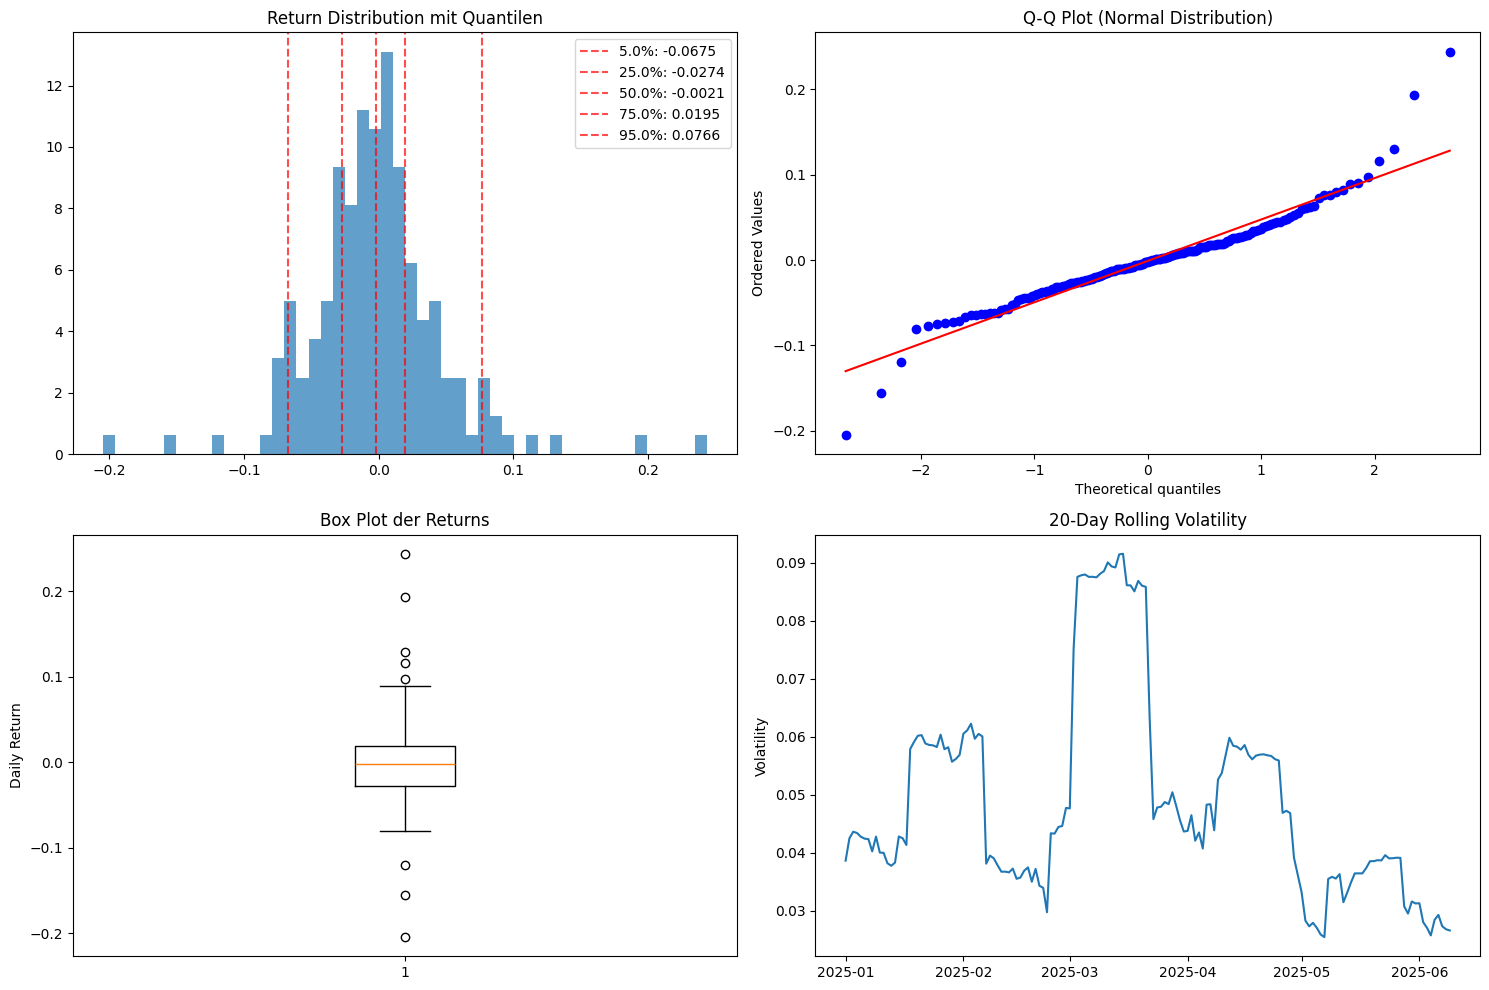

In [21]:
# visualization

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# histogram return
axes[0,0].hist(df["return"].dropna(), bins=50, alpha=0.7, density=True)
for q_val in [0.05, 0.25, 0.5, 0.75, 0.95]:
    axes[0,0].axvline(df["return"].quantile(q_val), 
                      color='red', linestyle='--', alpha=0.7,
                      label=f'{q_val*100}%: {df["return"].quantile(q_val):.4f}')
axes[0,0].set_title("Return Distribution with Quantiles")
axes[0,0].legend()

# q-q plot normal distribution 
stats.probplot(df["return"].dropna(), dist="norm", plot=axes[0,1])
axes[0,1].set_title("Q-Q Plot (Normal Distribution)")

# box plot
axes[1,0].boxplot(df["return"].dropna())
axes[1,0].set_title("Box Plot der Returns")
axes[1,0].set_ylabel("Daily Return")

# rolling volatility
df["rolling_vol"].plot(figsize=(12, 4), title="20-Day Rolling Volatility")
df["rolling_vol"] = df["return"].rolling(window=20).std()
axes[1,1].plot(df.index, df["rolling_vol"])
axes[1,1].set_title("20-Day Rolling Volatility")
axes[1,1].set_ylabel("Volatility")

plt.tight_layout()
plt.show()

In [ ]:
# Mean return:
# -0.00106 ≈ -0.1%
# This means the average daily return is slightly negative,
# indicating a daily loss of about 0.1% on average.

# Volatility (standard deviation of returns):
# 0.0501 ≈ 5%
# This shows the typical daily return fluctuations,
# meaning returns usually vary ±5% around the mean.

# Skewness:
# 0.5975 > 0
# The distribution is right-skewed, which means
# there are more frequent positive outliers,
# i.e., days with higher gains than losses.

# Kurtosis:
# 5.19 > 3 (normal distribution kurtosis is 3)
# This indicates the distribution has sharper peaks and fatter tails
# compared to a normal distribution,
# meaning there are more extreme values (outliers).
